# Prognosis on Affr values using classical models

### Data preproccesing

In [37]:
import pandas as pd 
import os
import sys
import glob

sys.path.append('./')

# Time zones of frequency recordings
tzs = {'DE':'CET'}

# Datetime parameters for output data generation
start = pd.Timestamp('2019-07-01 00:00:00', tz='UTC')
end = pd.Timestamp('2021-07-31 00:00:00', tz='UTC')
time_resol = pd.Timedelta('15min')


for area in ['DE']:
    
    print(area)
    
    # prepare folder for output data
    folder = './data/{}/'.format(area)
    if not os.path.exists(folder):
        os.makedirs(folder)    

    # Load FRR data
    outputs = pd.DataFrame()
    for file in glob.glob(folder + 'frr_data/activation/*.csv'): 
        
        print('Loading activated aFRR: ', file)
        frr= pd.read_csv(file , sep=';', low_memory=False,decimal=",")
        dt_index = (frr.DATE + ' ' + frr.TIME_FROM).astype('str')
        dt_index = pd.to_datetime(dt_index, format='%d.%m.%Y %H:%M').dt.tz_localize(tzs[area],
                                                                                    ambiguous='infer')
        frr.index=dt_index
        frr = frr.iloc[:,3:].sort_index()
        #outputs = outputs.append(frr)
        outputs = pd.concat([outputs, frr])

    # Filter aFRR data and shorten column names
    # Use quality assured data "QA", when available, otherwise use operational data ("OP")
    outputs_operat = outputs.filter(regex='AFRR').filter(regex='OP')
    outputs_quality = outputs.filter(regex='AFRR').filter(regex='QA')
    outputs_operat.columns = outputs_operat.columns.str[8:-8]
    outputs_quality.columns = outputs_quality.columns.str[8:-8]
    outputs = outputs_quality.where(outputs_quality.notnull(), outputs_operat)

    # Add additional target variables
    outputs.loc[:,'AFRR_DE_POS'] = outputs.filter(regex='POS').sum(1,skipna=False)
    outputs.loc[:,'AFRR_DE_NEG'] = outputs.filter(regex='NEG').sum(1,skipna=False)

    # Save data reindexed with full datetime index
    full_date_index = pd.date_range(start, end, freq=time_resol, tz='UTC')
    full_date_index = full_date_index.tz_convert(tzs[area])
    outputs = outputs.reindex(index=full_date_index)
    outputs.to_hdf(folder+'outputs.h5', key='df')  
        
    # Prepare aFRR tendering data
    demand_data = pd.DataFrame()
    for file in glob.glob(folder + 'frr_data/demand/*.xlsx'):
        
        print('Loading aFRR demand: ', file)
        
        demand=pd.read_excel(file)
        demand['datetime'] = demand.DATE_FROM.dt.strftime('%Y-%m-%d') + ' ' + demand.PRODUCT.str[4:6] + ':00'
        demand['datetime'] = pd.to_datetime(demand['datetime']).dt.tz_localize(tzs[area], ambiguous='infer')
        demand['PRODUCT'] = demand.PRODUCT.str[:3]
        demand = demand.pivot(index='datetime', columns='PRODUCT', values='GERMANY_BLOCK_DEMAND_[MW]') 
        
        #demand_data = demand_data.append(demand)
        demand_data = pd.concat([demand_data, demand])

    
    # Save data reindexed with full datetime index

    # sum across all tsos for affr demand pos/neg
    
    demand_data = demand_data.reindex(index=full_date_index).ffill(limit=15)
    demand_data = demand_data.rename(columns={'POS':'AFRR_DE_POS', 'NEG':'AFRR_DE_NEG'})
    demand_data.to_hdf(folder+'afrr_demand.h5', key='df')  

    #save data  to a csv file
    demand_data.to_csv(folder+'frr_demand.csv', sep=';', decimal=',')


DE
Loading activated aFRR:  ./data/DE/frr_data/activation\20190701_20191231_NRV-cooperation_03082021_192248.csv
Loading activated aFRR:  ./data/DE/frr_data/activation\20200101_20201231_NRV-cooperation_03082021_192156.csv
Loading activated aFRR:  ./data/DE/frr_data/activation\20210101_20210731_NRV-cooperation_03082021_191934.csv
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-07-01_2019-07-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-08-01_2019-08-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-09-01_2019-09-30.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-10-01_2019-10-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-11-01_2019-11-30.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2019-12-01_2019-12-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-01-01_2020-01-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-02-01_2020-02-29.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-03-01_2020-03-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-04-01_2020-04-30.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-05-01_2020-05-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-06-01_2020-06-30.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-07-01_2020-07-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-08-01_2020-08-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-09-01_2020-09-30.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-10-01_2020-10-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-11-01_2020-11-30.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2020-12-01_2020-12-31.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-01-01_2021-01-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-02-01_2021-02-28.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-03-01_2021-03-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-04-01_2021-04-30.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-05-01_2021-05-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-06-01_2021-06-30.xlsx
Loading aFRR demand:  ./data/DE/frr_data/demand\LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2021-07-01_2021-07-31.xlsx


C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\dvouk\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [38]:
outputs

,AFRR_50HERTZ_POS,AFRR_50HERTZ_NEG,AFRR_TRANSNETBW_POS,AFRR_TRANSNETBW_NEG,AFRR_TENNET_POS,AFRR_TENNET_NEG,AFRR_AMPRION_POS,AFRR_AMPRION_NEG,AFRR_DE_POS,AFRR_DE_NEG
2019-07-01 02:00:00+02:00,0.020,0.800,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:15:00+02:00,0.000,0.588,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:30:00+02:00,0.000,0.620,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:45:00+02:00,0.000,0.480,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 03:00:00+02:00,0.000,0.552,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-31 01:00:00+02:00,0.798,0.000,6.230,53.428,0.629,7.978,0.031,1.013,7.688,62.419
2021-07-31 01:15:00+02:00,0.216,0.020,0.228,154.963,0.041,11.831,0.020,0.991,0.505,167.805
2021-07-31 01:30:00+02:00,0.070,1.080,0.400,355.321,0.017,34.871,0.000,15.184,0.487,406.456
2021-07-31 01:45:00+02:00,0.054,11.098,0.000,582.422,0.080,67.549,0.092,94.694,0.226,755.763


In [39]:
demand_Afrr = pd.read_hdf(r'C:\Users\dvouk\Desktop\Dtu\Thesis pre\Thesis_project\data\DE\afrr_demand.h5', key='df')
demand_Afrr = demand_Afrr.rename(columns={'AFRR_DE_POS':'aFRR_POS_demand', 'AFRR_DE_NEG':'aFRR_NEG_demand'})
demand_Afrr

activation_df = pd.read_hdf(r'C:\Users\dvouk\Desktop\Dtu\Thesis pre\Thesis_project\data\DE\outputs.h5', key='df')
activation_df = activation_df.rename(columns={'AFRR_DE_POS':'aFRR_POS_activation', 'AFRR_DE_NEG':'aFRR_NEG_activation'})
activation_df

,AFRR_50HERTZ_POS,AFRR_50HERTZ_NEG,AFRR_TRANSNETBW_POS,AFRR_TRANSNETBW_NEG,AFRR_TENNET_POS,AFRR_TENNET_NEG,AFRR_AMPRION_POS,AFRR_AMPRION_NEG,aFRR_POS_activation,aFRR_NEG_activation
2019-07-01 02:00:00+02:00,0.020,0.800,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:15:00+02:00,0.000,0.588,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:30:00+02:00,0.000,0.620,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 02:45:00+02:00,0.000,0.480,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2019-07-01 03:00:00+02:00,0.000,0.552,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-31 01:00:00+02:00,0.798,0.000,6.230,53.428,0.629,7.978,0.031,1.013,7.688,62.419
2021-07-31 01:15:00+02:00,0.216,0.020,0.228,154.963,0.041,11.831,0.020,0.991,0.505,167.805
2021-07-31 01:30:00+02:00,0.070,1.080,0.400,355.321,0.017,34.871,0.000,15.184,0.487,406.456
2021-07-31 01:45:00+02:00,0.054,11.098,0.000,582.422,0.080,67.549,0.092,94.694,0.226,755.763


# Prognosis on Affr values using classical models


## Linear regression model 

#### Toy example
First we are going to develop a toy example on a small set in order to understand how the model works on different features and check some intervals on forecast target as well. This would be the base for our real model on actual data.


In [ ]:
import pandas as pd
import warnings
import numpy as np
import plotly.express as px

warnings.filterwarnings("ignore", category=UserWarning, module='plotly')


In [ ]:
# Read the data , data is fetched from a previous project

df = pd.read_csv(r'C:\Users\dvouk\Desktop\Dtu\Thesis pre\Thesis_project\weather_ts_train.csv', sep=',')

df.shape

(1462, 5)

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


##### Time step Feature
We index each date with a time 

In [ ]:
df["date"] = np.arange(len(df.index))
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,0,10.000000,84.500000,0.000000,1015.666667
1,1,7.400000,92.000000,2.980000,1017.800000
2,2,7.166667,87.000000,4.633333,1018.666667
3,3,8.666667,71.333333,1.233333,1017.166667
4,4,6.000000,86.833333,3.700000,1016.500000


In [ ]:
from sklearn.linear_model import LinearRegression

X = df['date'].values.reshape(-1, 1)  # Reshape to 2D array
y = df['meantemp']  # Target variable

# Train the model

model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

y_pred = pd.Series(model.predict(X), index=df.index)

# Obtain model coefficients and intercept
model.intercept_, model.coef_

# Plot the data points and the regression line

fig = px.line(df, x='date', y='meantemp', title='Mean temperature over time', labels={'date': 'Date', 'meantemp': 'meantemp (°C)'})
fig.add_scatter(x=df['date'], y=predictions, mode='lines', name='Regression Line')
fig.show()

  

##### Lag feature
The regression line doesnt really model the time dependece we will need more complex Timeseries model 



In [ ]:
df["Lag1"] = df["meantemp"].shift(1)
df.head()


,date,meantemp,humidity,wind_speed,meanpressure,Lag1
0,0,10.000000,84.500000,0.000000,1015.666667,NaN
1,1,7.400000,92.000000,2.980000,1017.800000,10.000000
2,2,7.166667,87.000000,4.633333,1018.666667,7.400000
3,3,8.666667,71.333333,1.233333,1017.166667,7.166667
4,4,6.000000,86.833333,3.700000,1016.500000,8.666667


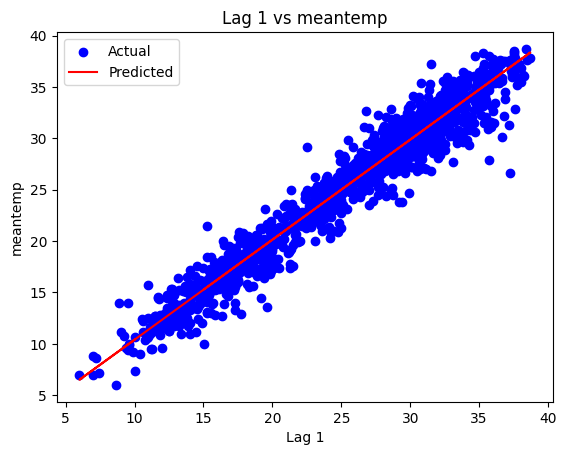

In [ ]:
# Remove Nan values (first row) and generate the new dataframe
df = df.dropna()
df_lag =df.copy()

# Training data
X_lag = df_lag[['Lag1']] #feature
y_lag = df_lag['meantemp'] #target

# Train the model
model_lag = LinearRegression()
model_lag.fit(X_lag, y_lag)

# Make predictions
predictions_lag = model_lag.predict(X_lag)
y_lag_pred = pd.Series(model_lag.predict(X_lag), index=df_lag.index)

# Obtain model coefficients and intercept
model_lag.intercept_, model_lag.coef_

# Plot the lag 1 against the temperature

import matplotlib.pyplot as plt

plt.scatter(X_lag, y_lag, color='blue', label='Actual')
plt.plot(X_lag, y_lag_pred, color='red', label='Predicted')
plt.xlabel('Lag 1')
plt.ylabel('meantemp')
plt.title('Lag 1 vs meantemp')
plt.legend()
plt.show()

#### Actual model

The actual model is build on data from German, focusing on activated afrr reserves from 4 different tsos of german grid in a period of almsot two years. Our goal is to build a model that use these activated results and predict the future assuming that the system conditions remain the same.

In this  first approach, we assume that our data are linear and towards this assumption we use a simple linear regression model with Ordinary Least Square estimators. 

In [57]:
df = pd.read_csv(r'C:\Users\dvouk\Desktop\Dtu\Thesis pre\Thesis_project\data\DE\frr_demand.csv', sep=';', decimal=',')
df.shape

(73057, 3)

In [58]:
df.head()

,Unnamed: 0,AFRR_DE_NEG,AFRR_DE_POS
0,2019-07-01 02:00:00+02:00,NaN,NaN
1,2019-07-01 02:15:00+02:00,NaN,NaN
2,2019-07-01 02:30:00+02:00,NaN,NaN
3,2019-07-01 02:45:00+02:00,NaN,NaN
4,2019-07-01 03:00:00+02:00,NaN,NaN


In [59]:
# Rename the first column to 'date' and ensure proper datetime conversion
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Convert the 'date' column to datetime, ensuring proper handling of timezone-aware strings
df['date'] = pd.to_datetime(df['date'], utc=True, format='ISO8601')  # Convert to UTC
df['date'] = df['date'].dt.tz_convert('CET')  # Convert to CET timezone
df['date'] = df['date'].dt.tz_localize(None)  # Remove timezone information

df.head()

,date,AFRR_DE_NEG,AFRR_DE_POS
0,2019-07-01 02:00:00,NaN,NaN
1,2019-07-01 02:15:00,NaN,NaN
2,2019-07-01 02:30:00,NaN,NaN
3,2019-07-01 02:45:00,NaN,NaN
4,2019-07-01 03:00:00,NaN,NaN


##### Time index 

In [81]:
df["date"] = np.arange(len(df.index))
# remove nan values
df = df.dropna()

df.head()

,date,AFRR_DE_NEG,AFRR_DE_POS,Lag1
105,0,1781.0,1889.0,1781.0
106,1,1781.0,1889.0,1781.0
107,2,1781.0,1889.0,1781.0
108,3,1781.0,1889.0,1781.0
109,4,1781.0,1889.0,1781.0


In [83]:
from sklearn.linear_model import LinearRegression

X = df['date'].values.reshape(-1, 1)  # Reshape to 2D array
y = df['AFRR_DE_NEG']  # Target variable

# Train the model

model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

y_pred = pd.Series(model.predict(X), index=df.index)

# Obtain model coefficients and intercept
model.intercept_, model.coef_

# Plot the data points and the regression line

fig = px.line(df, x='date', y='AFRR_DE_NEG', title='AFRR_DE_NEG', labels={'date': 'Date', 'meantemp': 'meantemp (°C)'})
fig.add_scatter(x=df['date'], y=predictions, mode='lines', name='Regression Line')
fig.show()

##### Model evaluation (visually)

As it is obvious from this plot, we notice that the regression line does not really model the dependence on time.
The regression line is almost flat relative to the high variation in the actual values, suggesting that the model is underfitting.
We will need a more complex model that could capture the dynamics in our time series.

Towards this approach, we could use some other classical timeseries models such as arima or sarima that adds the seasonality support as well before moving further in ML models.

##### Lag feature 

Adding lags on the current model.


In [71]:
df["Lag1"] = df["AFRR_DE_NEG"].shift(96)
df.head()


,date,AFRR_DE_NEG,AFRR_DE_POS,Lag1
9,9,1781.0,1889.0,NaN
10,10,1781.0,1889.0,NaN
11,11,1781.0,1889.0,NaN
12,12,1781.0,1889.0,NaN
13,13,1781.0,1889.0,NaN
